<a href="https://colab.research.google.com/github/makkimaki/pytorch-practice/blob/main/1_3_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!git clone https://github.com/YutaroOgawa/pytorch_advanced.git
!ls
%cd "pytorch_advanced"
%cd "1_image_classification"

Cloning into 'pytorch_advanced'...
remote: Enumerating objects: 552, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 552 (delta 36), reused 61 (delta 31), pack-reused 479
Receiving objects: 100% (552/552), 17.80 MiB | 29.50 MiB/s, done.
Resolving deltas: 100% (295/295), done.
data  pytorch_advanced	sample_data
/content/pytorch_advanced
/content/pytorch_advanced/1_image_classification


In [9]:
# パッケージのimport
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [10]:
# make_folders_and_data_downloads.ipynbの中身を実行
import os
import urllib.request
import zipfile


data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
save_path = os.path.join(data_dir, "imagenet_class_index.json")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
save_path = os.path.join(data_dir, "hymenoptera_data.zip")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

    # ZIPファイルを読み込み
    zip = zipfile.ZipFile(save_path)
    zip.extractall(data_dir)  # ZIPを解凍
    zip.close()  # ZIPファイルをクローズ

    # ZIPファイルを消去
    os.remove(save_path)
    
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [17]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            "train": transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            "val": transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase="train"):
        return self.data_transform[phase](img)

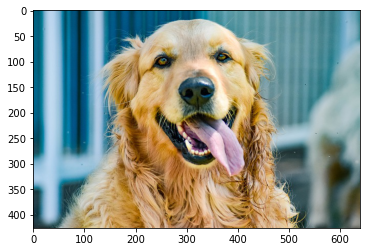

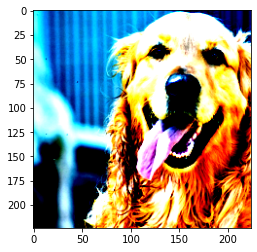

In [18]:
# 訓練時の画像前処理の動作を確認
# 実行するたびに処理結果の画像が変わる

#1. 画像読み込み
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)

#2. 元の画像の表示
plt.imshow(img)
plt.show()

#3. 画像の前処理と処理済み画像の表示
size = 224 
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std) 
img_transformed = transform(img, phase="train")

img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [22]:
def make_datapath_list(phase="train"):
    root_path = "./data/hymenoptera_data/"
    target_path = osp.join(root_path + phase + "/**/*.jpg")
    print(target_path)

    path_list = []

    # globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list 

train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

print(train_list[0][30:34])
print(val_list[30][28:32])

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg
ants
ants


In [27]:
# アリとハチの画像のDatasetを作成する

class HymenopteraDataset(data.Dataset):

    def __init__(self, file_list, transform=None, phase="train"):
        self.file_list = file_list 
        self.transform = transform 
        self.phase = phase 

    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        img_transformed = self.transform(
            img, self.phase)   # torch.Size([3, 224, 224])

        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]

        # ラベルを数値に変更する
        if label == "ants":
            label = 0
        elif label == "bees":
            lable = 1 
        
        return img_transformed, label 


train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase="train"
    )
val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase="val"
    )

# 動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])
print("---"*10)
print(val_dataset.__getitem__(index)[0].size())
print(val_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0
------------------------------
torch.Size([3, 224, 224])
0


In [31]:
batch_size = 32 

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, 
    shuffle=True
    )
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False
    )

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

batch_iterator = iter(dataloaders_dict["train"])
inputs, labels = next(
    batch_iterator)  # 1番目の要素を取り出す ←なぜかnext( から改行してbatch_iteratorと書かないとエラーがでる・・・
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
('bees', 'bees', 'bees', 0, 0, 0, 0, 0, 0, 'bees', 0, 0, 0, 'bees', 'bees', 'bees', 0, 'bees', 'bees', 'bees', 0, 'bees', 0, 0, 0, 'bees', 'bees', 'bees', 'bees', 0, 0, 'bees')


In [32]:
# ネットワークモデルの作成

use_pretrained = True 
net = torchvision.models.vgg16(pretrained=use_pretrained)
print(net)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [33]:
# VGG16の最後の出力層の出力ユニットをアリとハチの2つに付け替える
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)
# 訓練モードに設定
net.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [39]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# 例
name, param = next(net.named_parameters())
print(name)
print("="*50)
print(type(param))
print(param)

features.0.weight
<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
          [-5.8312e-01,  3.5655e-01,  7.6566e-01],
          [-6.9022e-01, -4.8019e-02,  4.8409e-01]],

         [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
          [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
          [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],

         [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
          [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
          [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],


        [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
          [-4.2805e-01, -2.4349e-01,  2.4628e-01],
          [-2.5066e-01,  1.4177e-01, -5.4864e-03]],

         [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
          [-8.4127e-01, -3.5176e-01,  5.6398e-01],
          [-2.4194e-01,  5.1928e-01,  5.3915e-01]],

         [[-3.1432e-01, -3.7048e-01, -1.3094e-01],
          [-4.7144e-01, -1.5503e-01,  3.4589e-01],
          [ 5.4384e-02,  5.8683e-01,  4.95

In [40]:
# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

# 学習させるパラメータ名
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else: 
        param.requires_grad = False

# params_to_updateの中身
print("="*30)
print(params_to_update)
print("num of components: ", len(params_to_update))


classifier.6.weight
classifier.6.bias
[Parameter containing:
tensor([[-0.0011,  0.0155, -0.0108,  ...,  0.0071,  0.0072, -0.0002],
        [-0.0148, -0.0075, -0.0127,  ...,  0.0052, -0.0043,  0.0156]],
       requires_grad=True), Parameter containing:
tensor([-0.0005,  0.0056], requires_grad=True)]
num of components:  2


In [41]:
# 最適化手法の設定
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)